In [1]:
import numpy as onp
import jax.numpy as np
from jax import random
from jax import jit
from jax_md.util import *
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax_md import quantity

from jax_pd import space, materials, damage, mesh, plots, solvers, util


/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [18]:
displacement_fn, shift_fn = space.free()

R = np.array([[i,j,k] for i in range(30) for j in range(3) for k in range(3)],dtype=np.float32)

bonds, lengths = util.bonds_n_lengths(R,cutoff=f32(2))

energy_fn = [materials.simple_spring_bond(displacement_fn, bond=bonds, length=lengths, epsilon=100, stretch=0.5)]


In [19]:
def move(R,bool,t=0,R0=R,v=np.array([[0.01,0,0]])):
    return R0[bool,:]+t*v

def fix(R,bool,t=0,R0=R):
    return R0[bool,:]


Rbc = []

iVbc = [{'bool':R[:,0]>26.5,'fn':fix,'kwargs':{'R0':R*0-np.array([[10,0,0]])}},
       {'bool':R[:,0]<2.5,'fn':fix,'kwargs':{'R0':R*0+np.array([[10,0,0]])}},
       ]


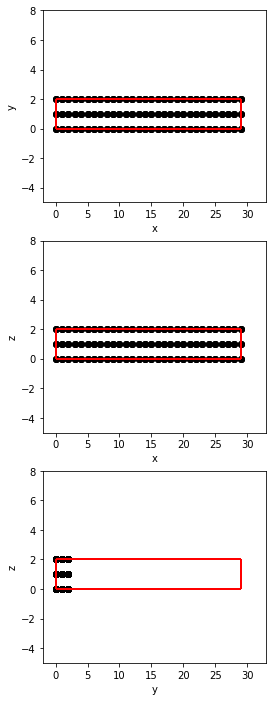

In [31]:
R1 = [R]

def myplot(i):
    x,y = 1,3
    fig, axs = plt.subplots(y,x,figsize=[4*x,4*y])
    ls = []
    ms = 5
    labels = [['x','y'],['x','z'],['y','z']]
    for ax,label in zip(axs,labels):
        ls.append(ax.plot([],[],'o', markersize=ms)[0])
        ax.set_xlim([-2, 33])
        ax.set_ylim([-5, 8])
        ax.hlines(0,0,29,zorder=10,color='r',lw=2)
        ax.hlines(2,0,29,zorder=10,color='r',lw=2)
        ax.vlines(0,0,2,zorder=10,color='r',lw=2)
        ax.vlines(29,0,2,zorder=10,color='r',lw=2)
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.axis('on')

    plots.W3(i,R1,axs,color='k')
    plt.show()

myplot(0)


In [33]:
R1 = [R]
runs = 5000
R2, state_values, states = solvers.run_simulation(key,runs,1.0e-3, R,energy_fn,shift_fn,iVbc=iVbc,mass=1.0,print_every=500,value_every=3,pos_every=1)

R1 += R2

Initial conditions(after iBC): 
KE: 2700.000000, PE: 0.000, TE: 2700.000
Initial conditions(after BC): 
KE: 2700.000000, PE: 0.000, TE: 2700.000
KE: 2699.475830, PE: 0.525, TE: 2700.001
KE: 1312.918823, PE: 1387.139, TE: 2700.058
KE: 863.002930, PE: 1837.060, TE: 2700.062
KE: 1524.497070, PE: 1175.548, TE: 2700.045
KE: 1572.185303, PE: 1127.860, TE: 2700.045
KE: 727.940186, PE: 1972.142, TE: 2700.082
KE: 1852.993530, PE: 847.042, TE: 2700.036
KE: 1521.483154, PE: 1178.556, TE: 2700.040
KE: 465.877625, PE: 2234.208, TE: 2700.085
KE: 1633.772339, PE: 1066.280, TE: 2700.053
KE: 1319.864624, PE: 1380.189, TE: 2700.053


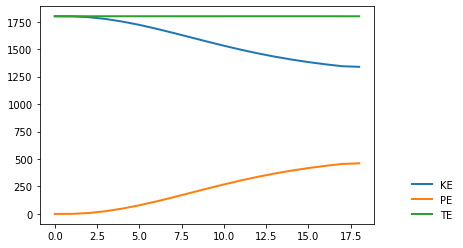

In [6]:
plt.plot(range(len(state_values)),np.array(state_values),lw=2)
plt.legend(['KE','PE','TE'],frameon=False,loc=[1.1,0])

In [10]:
F1 = []
F2 = []
mask1 = R[:,0]>6.5
mask2 = R[:,0]<2.5

F1 += [(state.acceleration[mask1,0]*state.mass).sum() for state in states]
F2 += [(state.acceleration[mask2,0]*state.mass).sum() for state in states]
    

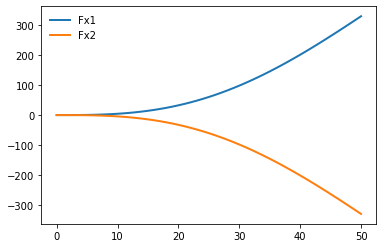

In [11]:
plt.plot(range(len(F1)),F1,label='Fx1',lw=2)
plt.plot(range(len(F2)),F2,label='Fx2',lw=2)
plt.legend(frameon=0)


In [16]:
from jax_md import quantity
force = [quantity.canonicalize_force(i, quantity.Energy) for i in energy_fn]

F1 = []
F2 = []
mask1 = R[:,0]>6.5
mask2 = R[:,0]<2.5

for i in range(len(R1)):
    F1 += [sum([f(R1[i],t=i) for f in force])[mask1,0].sum()]
    F2 += [sum([f(R1[i],t=i) for f in force])[mask2,0].sum()]
    

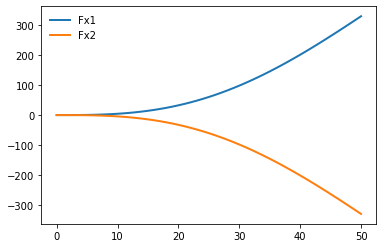

In [17]:
plt.plot(range(len(F1)),F1,label='Fx1',lw=2)
plt.plot(range(len(F2)),F2,label='Fx2',lw=2)
plt.legend(frameon=0)

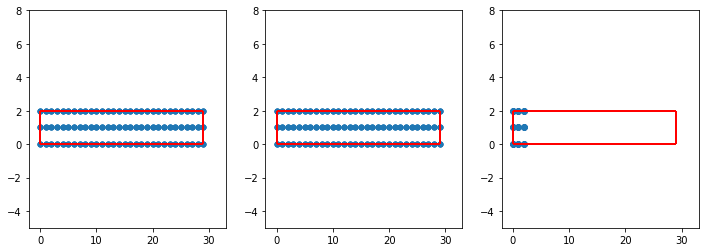

In [34]:
import matplotlib
k = 100
ms = 5

def myplot(i):
    global ax,l,k
    i = i*k
    R_plt = onp.array(R1[i])
    ls[0].set_data(R_plt[:, 0], R_plt[:, 1],) 
    ls[1].set_data(R_plt[:, 0], R_plt[:, 2],) 
    ls[2].set_data(R_plt[:, 1], R_plt[:, 2],) 


fig, axs = plt.subplots(1,3,figsize=[12,4])
ls = []
for ax in axs:
    ls.append(ax.plot([],[],'o', markersize=ms)[0])
    ax.set_xlim([-2, 33])
    ax.set_ylim([-5, 8])
    ax.hlines(0,0,29,zorder=10,color='r',lw=2)
    ax.hlines(2,0,29,zorder=10,color='r',lw=2)
    ax.vlines(0,0,2,zorder=10,color='r',lw=2)
    ax.vlines(29,0,2,zorder=10,color='r',lw=2)
    ax.axis('on')


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, myplot, frames=int(len(R1)/k))

from IPython.display import HTML
HTML(ani.to_jshtml())

In [38]:
with open('./dancing_bar.xyz','w+') as f:
    for r in R1:
        f.write(str(len(r))+'\n\n')        
        for i in r:
            f.write('{} {} {}\n'.format(*i))
        